Kickstarter es una plataforma de financiamiento colaborativo donde una persona puede pedir ayuda para realizar un proyecto de diversos temas, como juegos, peliculas, arte y muchos mas. El creador del proyecto sube a la plataforma el proyecto que desea hacer realidad, y las personas , si les gusta el proyecto, lo patrocinan.

Para más información ver el siguiente enlace: https://www.kickstarter.com/help/taxes?lang=es

En ele presente trabajo se tomó como base el dataset del siguiente enlace:
https://webrobots.io/kickstarter-datasets/
Este dataset contiene el registro de miles de proyectos de la plataforma Kickstarter, se puede saber en que fecha fueron creados, su categoría, y si fué exitoso o no.


El primer paso a seguir, luego de descargar los datos en formato csv, es consolidar todos ellos en un solo archivo para facilitar el procesamiento. A continuación el código en python 3 usado para esto

In [6]:
# Este código descargará archivos .csv en la carpeta actual, así que es necesario que no existan
# otros archivos .csv en la carpeta



# Paquetes a importar, para manejar los datos en un dataframe
import glob
import pandas
# Paquetes para descargar el archivo de la web y descomprimirlo
import requests, zipfile, io


def ReadFile(path):
    # Dada la ruta de un archivo, se lee este, y se separan ciertas columnas de interés para analizar
    # no todas las columnas tienen información relevante
    file = pandas.read_csv(path, skiprows = 0, sep = ',', header=0,
                 usecols = ['id', 'name', 'blurb', 'goal',
                            'state', 'pledged', 'state', 'country',
                            'currency', 'deadline', 'launched_at',
                            'backers_count', 'creator', 'location',
                            'category', 'spotlight', 'staff_pick'])

    # La columna location tiene un formato json con muchos campos innecesarios
    # se debe separar la información pedida, en este caso la ciudad en donde se realizó el proyecto
    file['location'] = file['location'].str.split('displayable_name').str[1]
    file['location'] = file['location'].str.split('"').str[2]
    
    # La columna creator tiene un formato json con muchos campos innecesarios
    # se debe separar la información pedida, en este caso el nombre de la persona o entidad que creó el proyecto
    file['creator'] = file['creator'].str.split(':').str[10]
    file['creator'] = file['creator'].str.split(',').str[0]
    
    # la columna category tambien tiene un formato json con campos innecesarios, se separa la categoría del proyecto
    file['category'] = file['category'].str.split(':').str[-1]
    file['category'] = file['category'].str.split('"').str[1]
    # Tambien se obtiene la subcategoría de cada proyecto
    file['subcategory'] = file['category'].str.split('/').str[1]
    file['category'] = file['category'].str.split('/').str[0]
    
    # Los campos deadline (que indica el momento en que terminó el proyecto) y 
    # launched_at (que indica el momento en que inició un proyecto) están en formato timestamp de unix
    # así que se deben transformar a una fecha legible
    file['deadline']=pandas.to_datetime(file['deadline'], unit='s')
    file['launced_at']=pandas.to_datetime(file['launched_at'], unit='s')
    
    # Este campo tiene la descripción del proyecto, para evitar problemas de lectura posteriores
    # se reemplazan los ; por .
    file['blurb'] = file['blurb'].replace(';', '.')
    
    # se filtran los proyectos por aquellos que fueron exitoso o fallidos
    # pues el objetivo es predecir si un poryecto será exitoso o no
    file.drop( 
            file[(file['state'] != 'successful') & (file['state'] != 'failed') ].index, 
            inplace = True)
  
    return file

# Se descarga el archivo .zip de la web del autor y se descomprime en la carpeta actual
# Descarga y descompresion de los archivos
url = "https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2017-10-15T10_20_38_271Z.zip"
r = requests.get(url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()



# Se toma el nombre de todos los archivos .csv que existan en la carpeta actual
pathFiles = glob.glob('*.csv')
# se descarta el archivo consolidado.csv, que será el archivo con todos los datos en uno solo
if ("consolidado.csv" in pathFiles):
    pathFiles.remove('consolidado.csv')
    
# este será el dataframe que contendrá la información
bigFile = pandas.DataFrame()
    
# Procesa cada archivo y lo anexa a un solo DataFrame
for path in pathFiles:
    print(path)
    bigFile = bigFile.append(ReadFile(path), ignore_index = True)

# eliminar filas duplicadas
bigFile.drop_duplicates(inplace = True)


# Guardar archivo
print("Guardando archivo consolidado")
bigFile.to_csv("consolidado.csv", sep = ";", na_rep = '', index = False)



UnsupportedOperation: seek

In [ ]:
Continuando con un análisis

A continuación se muestra un análisis de los proyectos por categorías

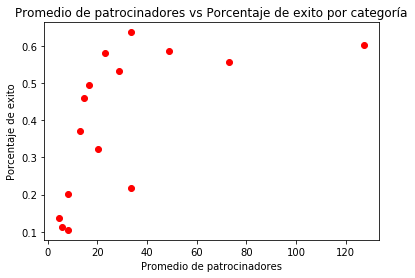

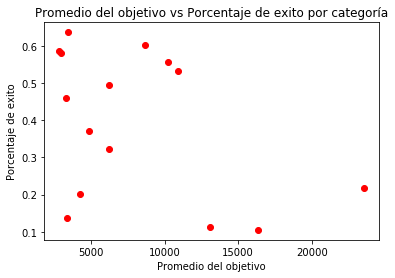



Correlación entre promedio de patrocinadores y porcentaje de exito entre categorias
0.586912149197


       Categoria  Patrocinadores     Exito  Cantidad      Objetivo
0         crafts        4.730455  0.135745      2571   3378.164138
1     journalism        5.620754  0.112611      2149  13110.000465
2    photography        7.987192  0.200768      3123   4233.782261
3           food        8.315099  0.104908      8007  16342.171725
4            art       13.169936  0.370636     12287   4882.194329
5          dance       14.788932  0.459459       777   3281.405405
6        theater       16.585227  0.494724      2464   6228.463880
7        fashion       20.411598  0.322752      5639   6208.324880
8          music       23.059355  0.580248     14287   2975.619154
9   film & video       28.627377  0.533627     17248  10908.208868
10    publishing       33.625167  0.636778     11197   3454.521522
11    technology       33.651016  0.217083     12843  23536.659965
12        comics       48.

In [1]:

import pandas 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import imp
imp.reload(plt)

# Leer el archivo consolidado
file = pandas.read_csv("consolidado.csv", skiprows = 0, sep = ';', header=0)

# Para obtener el promedio de exito, reemplazar un exito con 1, fracaso con 0
file['state'] = file['state'].replace('successful', 1)
file['state'] = file['state'].replace('failed', 0)


# Eliminar datos atípicos en cada categoría
# usar intervalo de confianza del 99%, y eliminar los mayores a estos, pues
# se consideran atípicos
categorias = file['category'].unique()
for cat in categorias:
    filec = file.loc[file['category'] == cat]
    # Se obtienen los indices de los valores atípicos para los campos
    # goal (objetivo) y backers_count (numero de patrocinadores)
    confianzaG = st.t.interval(0.99, 
                         len(filec)-1, 
                         loc=np.mean(filec['goal']), 
                         scale=st.sem(filec['goal']) ) 
    
    confianzaB = st.t.interval(0.99, 
                         len(filec)-1, 
                         loc=np.mean(filec['backers_count']), 
                         scale=st.sem(filec['backers_count'])  ) 
    
    # Se eliminan los proyectos con datos atípicos 
    file.drop( file[  (file['goal'] > confianzaG[1]) & 
                    (file['category'] == cat)  ].index , inplace = True ) 

    file.drop( file[  (file['backers_count'] > confianzaB[1] ) & 
                    (file['category'] == cat)  ].index , inplace = True ) 



# Por categoría, obtener la cantidad de proyectos,el porcentaje de exitos
# el promedio de patrocinadores
frecuenciaCategoria = file.groupby('category').agg(
        {'backers_count':'mean', 'state':'mean', 'category':'count',
         'goal': 'mean'}
   )
frecuenciaCategoria.columns = ['Patrocinadores', 'Exito', 'Cantidad', 'Objetivo']
frecuenciaCategoria.reset_index(inplace=True)
frecuenciaCategoria.columns = ['Categoria', 'Patrocinadores', 'Exito', 'Cantidad', 'Objetivo']


# reordenar según la cantidad de patrocinadores
frecuenciaCategoria.sort_values(by = ['Patrocinadores'], inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop = True)

# graficar la cantidad de patrocinadores vs en éxito obtenido
plt.figure()
plt.plot( list(frecuenciaCategoria['Patrocinadores']), 
          list(frecuenciaCategoria['Exito']),
          'ro')
plt.title('Promedio de patrocinadores vs Porcentaje de exito por categoría')
plt.xlabel('Promedio de patrocinadores')
plt.ylabel('Porcentaje de exito')
plt.show(block=False)


# graficar la cantidad de patrocinadores vs en éxito obtenido
plt.figure()
plt.plot( list(frecuenciaCategoria['Objetivo']), 
          list(frecuenciaCategoria['Exito']),
          'ro')
plt.title('Promedio del objetivo vs Porcentaje de exito por categoría')
plt.xlabel('Promedio del objetivo')
plt.ylabel('Porcentaje de exito')
plt.show(block=False)


print('')
print('')
  
print("Correlación entre promedio de patrocinadores y porcentaje de exito entre categorias")
print(np.corrcoef(list(frecuenciaCategoria['Patrocinadores']), 
                    list(frecuenciaCategoria['Exito']))[0][1]
)


print('')
print('')

print(frecuenciaCategoria)

Las gráficas anteriores indica que hay una tendencia a que los proyectos sean mas exitosos a medida que el proyecto tiene mas patrocinadores, que de hecho tiene una correlación de 0.58.
Respecto al tamaño del objetivo, aquellas categorías con objetivos muy altos tienen poca probabilidad de éxito.

A continuación se procede a buscar las categorías mas exitosas, así como las que tiene mas patrocinadores

In [2]:

frecuenciaCategoria.sort_values(
        by = ['Patrocinadores'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   


print("Categorías más apoyadas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Patrocinadores'])) 
          + ' patrocinadores por proyecto')
 
    
print('')
print('')

print("Categorías menos apoyadas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Patrocinadores']))  
          + ' patrocinadores por proyecto')
    

Categorías más apoyadas: 
games: 127 patrocinadores por proyecto
design: 72 patrocinadores por proyecto
comics: 48 patrocinadores por proyecto
technology: 33 patrocinadores por proyecto
publishing: 33 patrocinadores por proyecto


Categorías menos apoyadas: 
crafts: 4 patrocinadores por proyecto
journalism: 5 patrocinadores por proyecto
photography: 7 patrocinadores por proyecto
food: 8 patrocinadores por proyecto
art: 13 patrocinadores por proyecto


In [3]:
 # reordenar según el exito promedio de la categoría
frecuenciaCategoria.sort_values(
        by = ['Exito'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   
 
  
print("Categorías mas exitosas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Exito'] * 100))  
          + '%')
print('')
print('')    

print("Categorías menos exitosas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Exito'] * 100))  
          + '%')


Categorías mas exitosas: 
publishing: 63%
games: 60%
comics: 58%
music: 58%
design: 55%


Categorías menos exitosas: 
food: 10%
journalism: 11%
crafts: 13%
photography: 20%
technology: 21%


In [5]:
frecuenciaCategoria.sort_values(
        by = ['Objetivo'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   

print("Categorías más ambiciosas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Objetivo']))
          + '$ por proyecto')

print('')
print('')


print("Categorías menos ambiciosas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Objetivo']))
          + '$ por proyecto')    
    
 

Categorías más ambiciosas: 
technology: 23536$ por proyecto
food: 16342$ por proyecto
journalism: 13110$ por proyecto
film & video: 10908$ por proyecto
design: 10259$ por proyecto


Categorías menos ambiciosas: 
comics: 2856$ por proyecto
music: 2975$ por proyecto
dance: 3281$ por proyecto
crafts: 3378$ por proyecto
publishing: 3454$ por proyecto


Ahora un análisis específico a cada categoría





theater

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       10133.213655                 6.612048
1     Éxito        2240.429861                26.771124


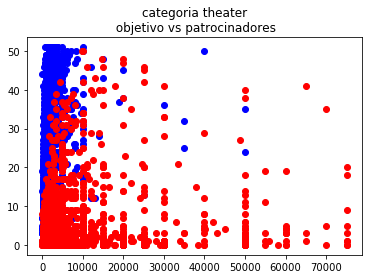





technology

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       26830.185837                16.602785
1     Éxito       11658.466765                95.135940


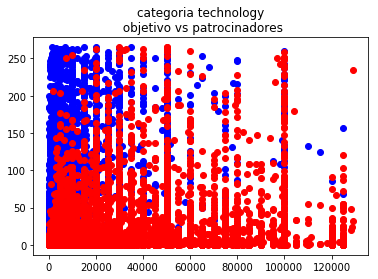





publishing

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        4718.297359                 7.748955
1     Éxito        2733.655276                48.385133


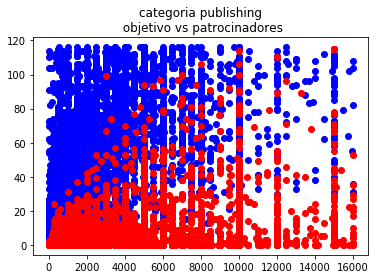





food

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       17879.194503                 6.258128
1     Éxito        3228.073810                25.865476


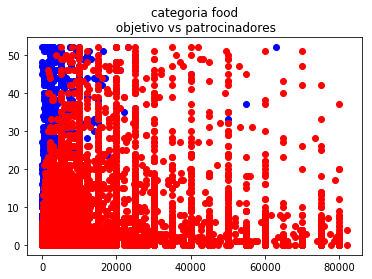





music

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        3915.179720                 6.193430
1     Éxito        2295.939455                35.260193


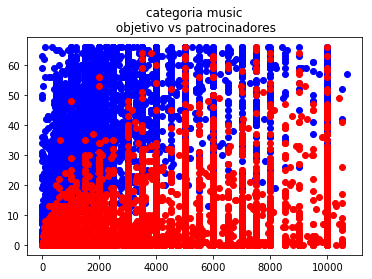





film & video

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       18287.609756                 8.572476
1     Éxito        4458.849813                46.154715


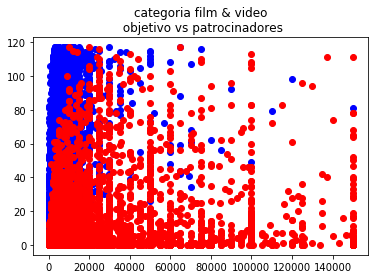





fashion

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        7116.543860                 8.004190
1     Éxito        4302.562088                46.446703


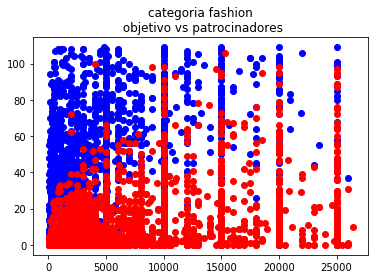





comics

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        3943.187807                17.054660
1     Éxito        2090.016823                71.176645


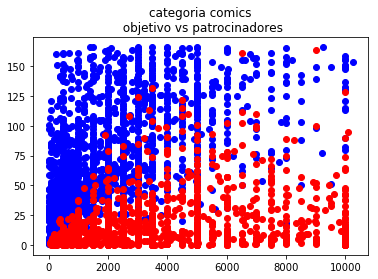





crafts

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        3797.694869                 3.283978
1     Éxito         707.111748                13.939828


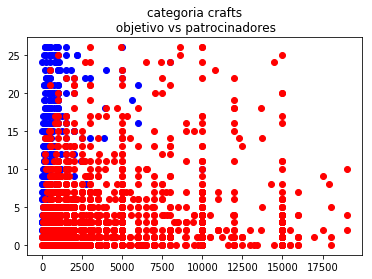





dance

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        4187.795238                 5.371429
1     Éxito        2215.064426                25.868347


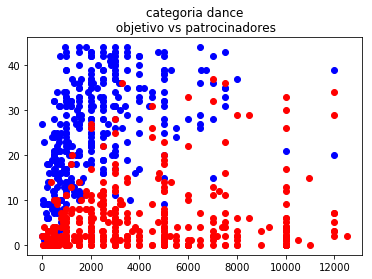





design

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       13413.921490                14.102006
1     Éxito        7737.850435               119.942281


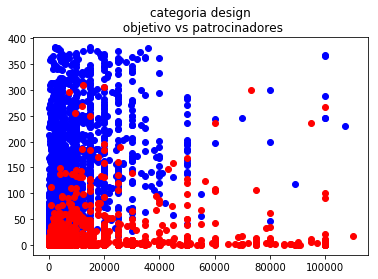





games

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       12177.094346                19.709331
1     Éxito        6377.628323               198.392988


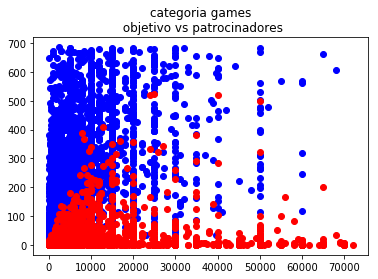





journalism

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido       14549.111169                 3.476141
1     Éxito        1769.570248                22.520661


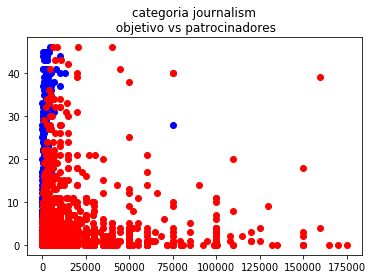





photography

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        4925.114984                 4.375401
1     Éxito        1481.682616                22.365231


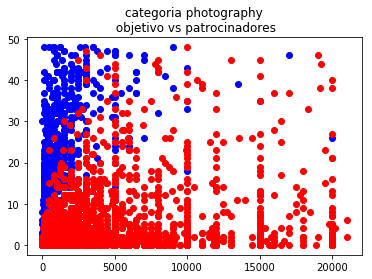





art

  Resultado  Objetivo promedio  Patrocinadores promedio
0   Fallido        6783.772052                 6.129833
1     Éxito        1653.186746                25.124506


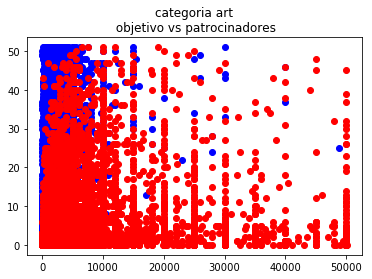

In [6]:

for cat in categorias:
    print('\n\n\n')
    print(cat)
    print('')
    
    filec = file.loc[file['category'] == cat]
    filec.reset_index(inplace=True, drop = True)
    
    # Por categoría, ver el objetivo promedio y patrocinadores promedio entre los
    # exitosos y no
    
    g = filec.groupby('state')[['goal', 'backers_count']].mean() 
    g.reset_index(inplace = True)
    g.columns = ['Resultado', 'Objetivo promedio', 'Patrocinadores promedio']
    g['Resultado'] = g['Resultado'].replace(0, 'Fallido')
    g['Resultado'] = g['Resultado'].replace(1, 'Éxito')
    print(g)
    
    
    exito = filec.loc[filec['state'] == 1]
    fallo = filec.loc[filec['state'] == 0]
    
    plt.plot(exito['goal'], exito['backers_count'], 'ro', color='blue')
    plt.plot(fallo['goal'], fallo['backers_count'], 'ro', color='red')
    plt.title("categoria " + cat + '\n objetivo vs patrocinadores')
    plt.show()

Lo anterior muestra que la tendencia a que los proyectos fallidos tengan objetivos más altos se mantiene incluso al interior de cada categoría, incluso, en muchas de las categorías, al sobrepasar cierto umbral del tamaño del objetivo la probabilidad


Sistema de predicción de exito o fracaso de un proyecto.

In [5]:
#Arbol con ensable de estimadores

from sklearn import tree  
import pydotplus  
from IPython.display import Image  
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

#Lectura archivo
data=pd.read_csv('consolidado.csv',  # el archivo
                    sep = ';',         # separador de campos
                    thousands = None,  # separador de miles para números
                    decimal = '.',
                    skiprows = 0,
                    header=0)     # separador de los decimales para números

#Semanas campaña
data['semanas_campana'] = ((pd.to_datetime(data['deadline']) - pd.to_datetime(data['launched_at']))/ np.timedelta64(1, 'W')).astype(int)

#Longitud descripcion
sizes = [len(i) for i in data['blurb'].astype(str)]
data['longitud_descripcion']=sizes

#Variables dummy de categoria
df_categoria = pd.get_dummies(data['category'])
data = data.join(df_categoria)

#Variables dummy de country
df_country = pd.get_dummies(data['country'])
data = data.join(df_country)

#Variables dummy de subcategory
df_subcategory = pd.get_dummies(data['subcategory'])
data = data.join(df_subcategory)

#Normalizar valor objetivo
#data['goal'] = preprocessing.scale(data['goal'])
#longitud_descripcion
cols = ['goal', 'semanas_campana', 'art', 'comics', 'crafts',
       'dance', 'design', 'fashion', 'film & video', 'food', 'games',
       'journalism', 'music', 'photography', 'publishing', 'technology',
       'theater', 
       'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 
'NZ', 'SE', 'SG', 'US', '3d printing', 'academic', 'accessories', 'action', 'animals', 'animation', 'anthologies', 
'apparel', 'apps', 'architecture', 'art books', 'audio', 'bacon', 'blues', 'calendars', 'camera equipment', 'candles', 
'ceramics', 'children\'s books', 'childrenswear', 'chiptune', 'civic design', 'classical music', 'comedy', 
'comic books', 'community gardens', 'conceptual art', 'cookbooks', 'country & folk', 'couture', 'crochet', 
'digital art', 'diy', 'diy electronics', 'documentary', 'drama', 'drinks', 'electronic music', 'embroidery', 
'events', 'experimental', 'fabrication tools', 'faith', 'family', 'fantasy', 'farmer\'s markets', 'farms', 
'festivals', 'fiction', 'fine art', 'flight', 'food trucks', 'footwear', 'gadgets', 'gaming hardware', 'glass', 
'graphic design', 'graphic novels', 'hardware', 'hip-hop', 'horror', 'illustration', 'immersive', 'indie rock', 
'installations', 'interactive design', 'jazz', 'jewelry', 'kids', 'knitting', 'latin', 'letterpress', 
'literary journals', 'literary spaces', 'live games', 'makerspaces', 'metal', 'mixed media', 'mobile games', 
'movie theaters', 'music videos', 'musical', 'narrative film', 'nature', 'nonfiction', 'painting', 'people', 
'performance art', 'performances', 'periodicals', 'pet fashion', 'photo', 'photobooks', 'places', 'playing cards', 
'plays', 'poetry', 'pop', 'pottery', 'print', 'printing', 'product design', 'public art', 'punk', 'puzzles', 
'quilts', 'r&b', 'radio & podcasts', 'ready-to-wear', 'residencies', 'restaurants', 'robots', 'rock', 'romance', 
'science fiction', 'sculpture', 'shorts', 'small batch', 'software', 'sound', 'space exploration', 'spaces', 
'stationery', 'tabletop games', 'taxidermy', 'television', 'textiles', 'thrillers', 'translations', 'typography', 
'vegan', 'video', 'video art', 'video games', 'wearables', 'weaving', 'web', 'webcomics', 'webseries', 'woodworking', 
'workshops', 'world music', 'young adult', 'zines', 'state'
]

data=data[cols]
# longitud_descripcion
data.columns=['goal', 'semanas_campana', 'art', 'comics', 'crafts',
       'dance', 'design', 'fashion', 'film \& video', 'food', 'games',
       'journalism', 'music', 'photography', 'publishing', 'technology',
       'theater',
       'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 
'NZ', 'SE', 'SG', 'US', '3d printing', 'academic', 'accessories', 'action', 'animals', 'animation', 'anthologies', 
'apparel', 'apps', 'architecture', 'art books', 'audio', 'bacon', 'blues', 'calendars', 'camera equipment', 'candles', 
'ceramics', 'children\'s books', 'childrenswear', 'chiptune', 'civic design', 'classical music', 'comedy', 
'comic books', 'community gardens', 'conceptual art', 'cookbooks', 'country \& folk', 'couture', 'crochet', 
'digital art', 'diy', 'diy electronics', 'documentary', 'drama', 'drinks', 'electronic music', 'embroidery', 
'events', 'experimental', 'fabrication tools', 'faith', 'family', 'fantasy', 'farmer\'s markets', 'farms', 
'festivals', 'fiction', 'fine art', 'flight', 'food trucks', 'footwear', 'gadgets', 'gaming hardware', 'glass', 
'graphic design', 'graphic novels', 'hardware', 'hip-hop', 'horror', 'illustration', 'immersive', 'indie rock', 
'installations', 'interactive design', 'jazz', 'jewelry', 'kids', 'knitting', 'latin', 'letterpress', 
'literary journals', 'literary spaces', 'live games', 'makerspaces', 'metal', 'mixed media', 'mobile games', 
'movie theaters', 'music videos', 'musical', 'narrative film', 'nature', 'nonfiction', 'painting', 'people', 
'performance art', 'performances', 'periodicals', 'pet fashion', 'photo', 'photobooks', 'places', 'playing cards', 
'plays', 'poetry', 'pop', 'pottery', 'print', 'printing', 'product design', 'public art', 'punk', 'puzzles', 
'quilts', 'r\&b', 'radio \& podcasts', 'ready-to-wear', 'residencies', 'restaurants', 'robots', 'rock', 'romance', 
'science fiction', 'sculpture', 'shorts', 'small batch', 'software', 'sound', 'space exploration', 'spaces', 
'stationery', 'tabletop games', 'taxidermy', 'television', 'textiles', 'thrillers', 'translations', 'typography', 
'vegan', 'video', 'video art', 'video games', 'wearables', 'weaving', 'web', 'webcomics', 'webseries', 'woodworking', 
'workshops', 'world music', 'young adult', 'zines', 'state'
]

cols=data.columns

data["state"]= data['state'].map({'successful': 1, 'failed': 0})
           
#data.to_csv("dataset_arbol.csv", sep = ";", na_rep = '', index = False)

features = list(cols[:183])
data = data.as_matrix()
data = np.matrix(data)

X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], np.ravel(data[:,183:184]), test_size=0.30, random_state=42)

tree1 = DecisionTreeClassifier()

bag = BaggingClassifier(tree1, n_estimators=100, max_samples=0.8, random_state=1)
bag1=bag.fit(X_train, y_train)


y_pred=bag1.predict(X_test)

accuracy = sm.accuracy_score(y_test, y_pred)

print("Precision: %.2f%%" % (accuracy*100.0))
print("MSE:",mean_squared_error(y_test, y_pred))

#Se deshabilitar el grafico del arbol porque no funciona al incluir el ensable de estimadores (BaggingClassifier)
#Se exporta el arbol al formato Graphviz 
#with open("iris.dot", 'w') as f:
#    f = tree.export_graphviz(bag1, out_file=f)
    
#export_graphviz soporta otras opciones tal como colorear y la funcion Image permite renderizar la imagen en el libro de Ipython
#dot_data = tree.export_graphviz(bag1, out_file=None, 
#                     feature_names=features,  
#                     class_names=['failed', 'succesful'],  
#                     filled=True, rounded=True,  
#                     special_characters=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())



/home/ricardo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


KeyboardInterrupt: 

Analisis de volumen de patrocinadores, valor metas y exito y fallo de una campaña

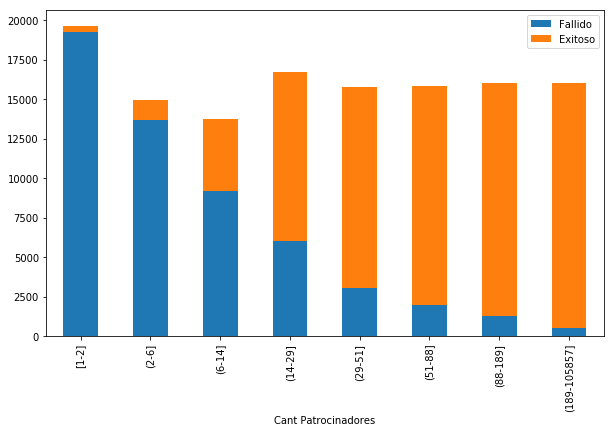

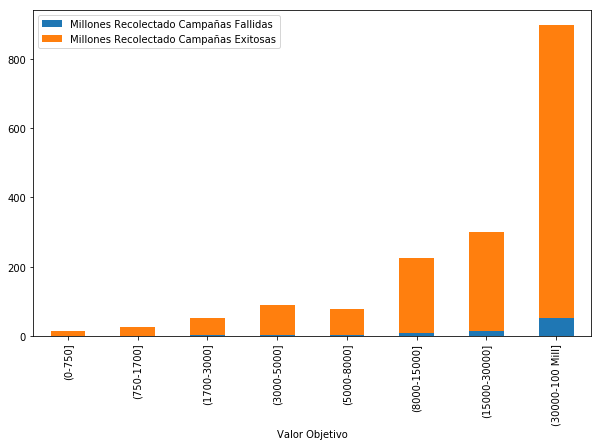

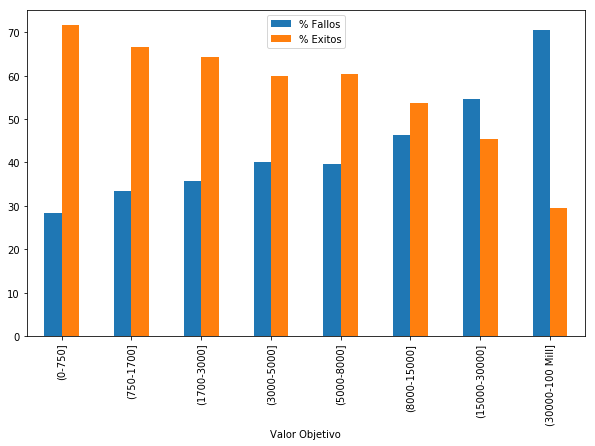

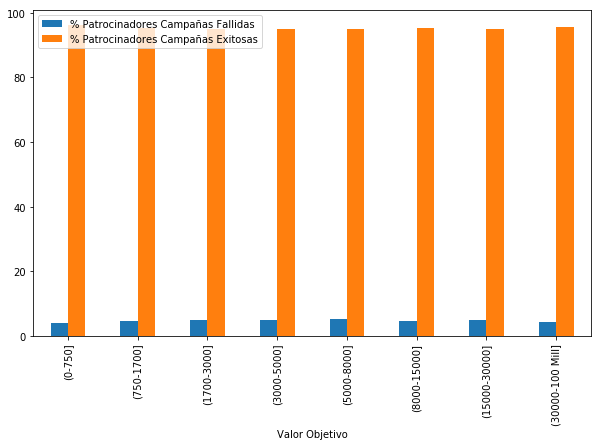

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Lectura archivo
data=pd.read_csv('consolidado.csv',  # el archivo
                    sep = ';',         # separador de campos
                    thousands = None,  # separador de miles para números
                    decimal = '.',
                    skiprows = 0,
                    header=0)     # separador de los decimales para números
labels=['[1-2]', '(2-6]', '(6-14]', '(14-29]', '(29-51]', '(51-88]', '(88-189]', '(189-105857]']
data_bakers=data.loc[data['backers_count'] > 0]
#print(data_bakers.columns)

data_bakers['Cant Patrocinadores']=pd.qcut(data_bakers['backers_count'], 8,labels=labels)

#Dinero obtenido
bins_dinero=data_bakers[['Cant Patrocinadores', 'goal', 'pledged']]

bins_dinero.columns=['Cant Patrocinadores', 'Objetivo', 'Obtenido']

bins_dinero=bins_dinero.groupby('Cant Patrocinadores').sum()

#Estados
df_state = pd.get_dummies(data_bakers['state'])
data_bakers = data_bakers.join(df_state)

bins_states=data_bakers[['Cant Patrocinadores', 'failed', 'successful']]

bins_states.columns=['Cant Patrocinadores', 'Fallido', 'Exitoso']

bins_states=bins_states.groupby('Cant Patrocinadores').sum()

#Objetivos vs patrocinadores

labels=['(0-750]', '(750-1700]', '(1700-3000]', '(3000-5000]', '(5000-8000]', '(8000-15000]', '(15000-30000]', '(30000-100 Mill]']
data_objetivo=data.loc[data['goal'] > 0]


#Objetivo vs Patrocinadores
df_state = pd.get_dummies(data_bakers['state'])
data_objetivo = data_objetivo.join(df_state)

data_objetivo['failed_bakers']=data_objetivo['failed']*data_objetivo['backers_count']
data_objetivo['successful_bakers']=data_objetivo['successful']*data_objetivo['backers_count']

data_objetivo['Valor Objetivo']=pd.qcut(data_objetivo['goal'], 8,labels=labels)

bins_objetivo_bakers=data_objetivo[['Valor Objetivo', 'failed_bakers', 'successful_bakers']]

bins_objetivo_bakers=bins_objetivo_bakers.groupby('Valor Objetivo').sum()

#print(bins_objetivo_bakers)
bins_objetivo_bakers_porc_falledo=(bins_objetivo_bakers['failed_bakers']/(bins_objetivo_bakers['failed_bakers']+bins_objetivo_bakers['successful_bakers']))*100
bins_objetivo_bakers_porc_exito=(bins_objetivo_bakers['successful_bakers']/(bins_objetivo_bakers['failed_bakers']+bins_objetivo_bakers['successful_bakers']))*100
bins_objetivo_bakers['successful_bakers']=bins_objetivo_bakers_porc_exito
bins_objetivo_bakers['failed_bakers']=bins_objetivo_bakers_porc_falledo

#print(bins_objetivo_bakers)

bins_objetivo_bakers.columns=['% Patrocinadores Campañas Fallidas', '% Patrocinadores Campañas Exitosas']



#Objetivos vs recolectado

data_objetivo['failed_recogido']=(data_objetivo['failed']*data_objetivo['pledged'])/1000000
data_objetivo['successful_recogido']=(data_objetivo['successful']*data_objetivo['pledged'])/1000000

bins_objetivo_recogido=data_objetivo[['Valor Objetivo', 'failed_recogido', 'successful_recogido']]

bins_objetivo_recogido.columns=['Valor Objetivo', 'Millones Recolectado Campañas Fallidas', 'Millones Recolectado Campañas Exitosas']

bins_objetivo_recogido=bins_objetivo_recogido.groupby('Valor Objetivo').sum()



#Objetivos vs exito

data_objetivo['failed_recogido']=(data_objetivo['failed']*data_objetivo['pledged'])/1000000
data_objetivo['successful_recogido']=(data_objetivo['successful']*data_objetivo['pledged'])/1000000

bins_objetivo_exito=data_objetivo[['Valor Objetivo', 'failed', 'successful']]

bins_objetivo_exito.columns=['Valor Objetivo', 'Fallido', 'Exitoso']

bins_objetivo_exito=bins_objetivo_exito.groupby('Valor Objetivo').sum()

bins_objetivo_exito_porc_falledo=(bins_objetivo_exito['Fallido']/(bins_objetivo_exito['Fallido']+bins_objetivo_exito['Exitoso']))*100
bins_objetivo_exito_porc_exito=(bins_objetivo_exito['Exitoso']/(bins_objetivo_exito['Fallido']+bins_objetivo_exito['Exitoso']))*100
bins_objetivo_exito['Exitoso']=bins_objetivo_exito_porc_exito
bins_objetivo_exito['Fallido']=bins_objetivo_exito_porc_falledo

bins_objetivo_exito.columns=['% Fallos', '% Exitos']

#El exito de un proyecto depende del volumen de apoyo que recibe.
bins_states.plot.bar(stacked=True,figsize=(10, 6));

#La cantidad de dinero recolectado aumenta con la meta. Entonces no se ve un fenomeno marcado de pocos dan mucho.
bins_objetivo_recogido.plot.bar(stacked=True,figsize=(10, 6));

#Mientras mayor sea la meta mas probabilidad de que falle el proyecto
bins_objetivo_exito.plot.bar(figsize=(10, 6));

#A pesar de que la probabilidad de fallo aumenta con el valor de  la meta, no cambia el porcentaje de patrocinadores 
# que apoyan las campañas exitosas. Es decir, muchos patrocinadores apoyan unos pocos proyectos
bins_objetivo_bakers.plot.bar(figsize=(10, 6));

plt.show()
